In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
from resnet import Resnet4Channel

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [3]:
np.random.seed(21)

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


### get better validation split since the classes are very unevenly represented

In [6]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_df_orig = df.copy()

train_df_orig['Target'] = train_df_orig.apply(lambda x: x['Target'].split(' '), axis=1)

X = train_df_orig['Id'].tolist()
y = train_df_orig['Target'].tolist()
y = MultiLabelBinarizer().fit_transform(y)

for train_index, val_index in msss.split(X,y): #it should only do one iteration
    print("Train:", train_index, "Valid:", val_index)

del X, y
gc.collect()

len(train_index), len(val_index), len(df)

Train: [    0     1     2     3 ... 31067 31069 31070 31071] Valid: [    9    40    55    67 ... 31044 31046 31059 31068]


(27958, 3114, 31072)

### set everything we need for creating a ImageMultiDataset

In [7]:
fns = pd.Series([id + '.png' for id in df.Id])
labels = [targ.split(' ') for targ in df.Target]
classes=[str(i) for i in range(28)]

In [8]:
trn_mask=[]

for i in range(len(df)):
    trn_mask.append(False if i in val_index else True)
    
len(trn_mask), trn_mask.count(True), trn_mask.count(False)

(31072, 27958, 3114)

### create train, valid and test ImageMultiDataset

In [9]:
trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)
trn_ds, val_ds

(ImageMulti4Channel of len 27958, ImageMulti4Channel of len 3114)

In [10]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [11]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 'test', pd.Series(test_ids),[['0'] for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

### define transforms, normalization and metric

In [12]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [13]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

### create ImageDataBunch from all this

In [14]:
torch.backends.cudnn.benchmark = True
src_size = 512

In [15]:
bs = 32

In [16]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size//2).normalize(protein_stats)

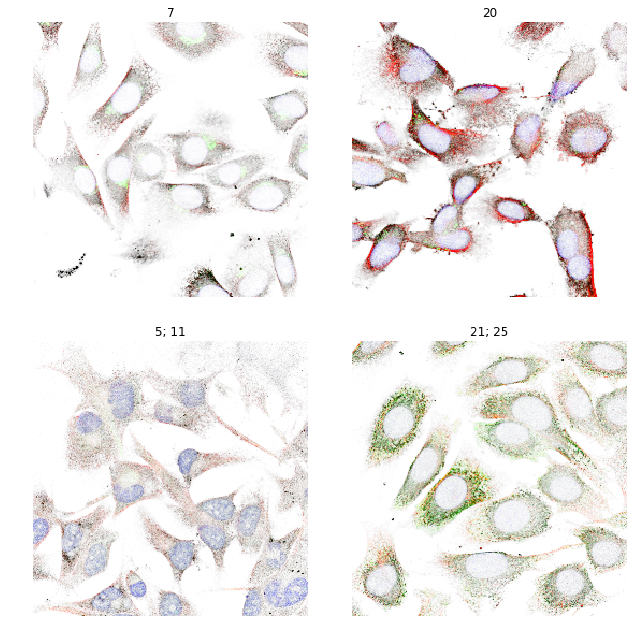

In [17]:
data.show_batch(rows=2, figsize=(9,9), ds_type=DatasetType.Valid)

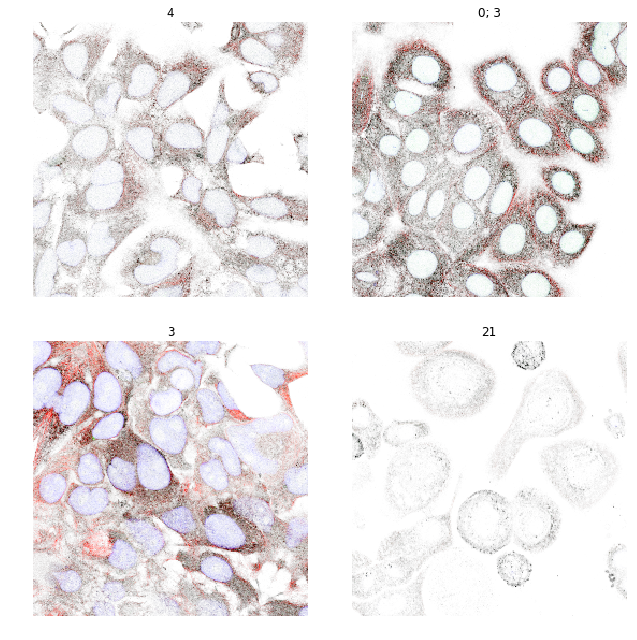

In [18]:
data.show_batch(rows=2, figsize=(9,9))

### create model and learner

In [19]:
def resnet34(pretrained=True):
    return Resnet4Channel(encoder_depth=34, pretrained=pretrained)

def resnet50(pretrained=True):
    return Resnet4Channel(encoder_depth=50, pretrained=pretrained)

In [20]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [21]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2]).to(torch.device("cuda"))

In [22]:
f1_score = partial(fbeta, thresh=0.2, beta=1) #thresh=weights

In [23]:
bce_logit_loss = partial(F.binary_cross_entropy_with_logits, weight=weights)

In [24]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=bce_logit_loss,
    path=path,    
    metrics=[f1_score], 
)

In [25]:
learn.loss_func

functools.partial(<function binary_cross_entropy_with_logits at 0x7f545e7b9620>, weight=tensor([0.5000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.2000,
        0.2000, 0.2000, 0.4000, 0.4000, 0.4000, 0.4000, 0.2000, 0.4000, 0.4000,
        0.4000, 0.4000, 0.2000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000,
        0.2000], device='cuda:0'))

In [26]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [27]:
learn.freeze()

In [28]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

### use lr find to get a good learning rate

In [43]:
learn.data.train_ds, learn.data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 27958),
 DatasetTfm(ImageMulti4Channel of len 3114))

In [37]:
learn.lr_find(num_it=300)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


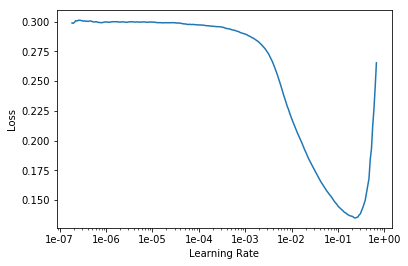

In [38]:
learn.recorder.plot() #with weighted loss

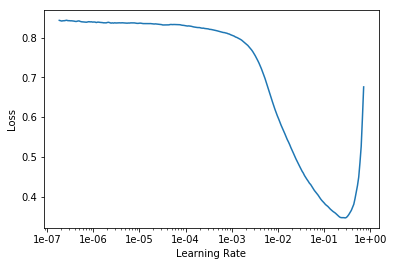

In [45]:
learn.recorder.plot() #with non weighted loss

In [44]:
lr = 3e-3

### fit the model (half image size)

In [45]:
#weights in the loss function seem to work great but weights on loss and thresh not
#probably because the loss function tends to need a 0.2 threshold when weighted 

In [ ]:
learn.fit_one_cycle(20, max_lr=slice(lr)) #with weighted loss 0.2 thresh metric

epoch,train_loss,valid_loss,fbeta


learn.save('protein_half_e20_weighted')

In [27]:
learn.fit_one_cycle(20, max_lr=slice(lr)) #with non weighted loss 0.2 thresh metric

Total time: 1:19:00
epoch  train_loss  valid_loss  fbeta   
1      0.152667    0.141839    0.457245  (03:56)
2      0.134953    0.124365    0.545845  (03:54)
3      0.120660    0.113558    0.590050  (03:55)
4      0.116280    0.109635    0.610782  (04:00)
5      0.115012    0.106997    0.618845  (04:04)
6      0.109067    0.105390    0.627223  (04:03)
7      0.107883    0.100927    0.652452  (04:02)
8      0.104741    0.100038    0.653827  (03:58)
9      0.104459    0.097151    0.655039  (03:56)
10     0.102050    0.096702    0.660374  (03:56)
11     0.101139    0.094517    0.674861  (03:57)
12     0.099062    0.092910    0.677003  (03:53)
13     0.097479    0.093394    0.674843  (03:54)
14     0.097021    0.090891    0.687790  (03:54)
15     0.095587    0.089628    0.685682  (03:54)
16     0.094466    0.089641    0.691044  (03:55)
17     0.090007    0.088806    0.694712  (03:53)
18     0.089883    0.088565    0.694448  (03:53)
19     0.088517    0.088111    0.697074  (03:58)
20     0.

### unfreeze there resnet layers and train again 

In [29]:
learn.load('protein_half_e20_weighted')

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


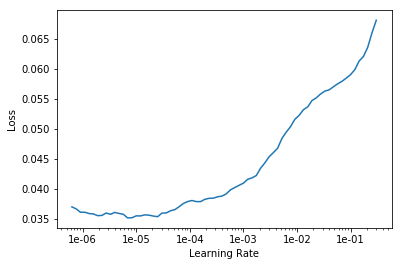

In [32]:
learn.recorder.plot()

In [33]:
lrs = slice(1e-5, 1e-6)

In [ ]:
learn.fit_one_cycle(30, max_lr=lrs)

epoch,train_loss,valid_loss,fbeta


In [ ]:
learn.save('protein_half_e30_unfrozen')

In [29]:
#learn.fit_one_cycle(12, max_lr=lrs)

Total time: 59:09
epoch  train_loss  valid_loss  fbeta   
1      0.099299    0.092940    0.681014  (04:55)
2      0.099179    0.092147    0.681692  (04:56)
3      0.099012    0.092941    0.675491  (04:59)
4      0.098476    0.092505    0.682270  (04:56)
5      0.096997    0.098259    0.684051  (04:44)
6      0.095017    0.089253    0.695495  (04:43)
7      0.093896    0.086938    0.701592  (04:50)
8      0.092313    0.085737    0.701541  (04:57)
9      0.089771    0.085350    0.710806  (04:58)
10     0.088331    0.084716    0.712809  (04:59)
11     0.087921    0.083999    0.715316  (05:05)
12     0.085289    0.083800    0.710998  (05:02)



In [30]:
#learn.save('protein_half_e12_unfrozen')

### train on whole picture (512px)

In [40]:
bs = 8

In [41]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(protein_stats)

In [42]:
def resnet34(pretrained=True):
    return Resnet4Channel(encoder_depth=34, pretrained=pretrained)

def resnet50(pretrained=True):
    return Resnet4Channel(encoder_depth=50, pretrained=pretrained)

In [43]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=bce_logit_loss,
    path=path,    
    metrics=[f1_score], 
)

In [45]:
learn.split(split_on=_resnet_split)

AttributeError: 'Sequential' object has no attribute 'layer3'

In [ ]:
learn.layer_groups

In [ ]:
learn.freeze()

In [ ]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

In [ ]:
learn.load('protein_half_e30_unfrozen')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-4

In [ ]:
learn.fit_one_cycle(20, max_lr=slice(lr))

In [ ]:
learn.save('protein_full_e20')

In [ ]:
#learn.load('protein_full_e20')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5, 1e-4)

In [ ]:
learn.fit_one_cycle(20, lrs)

In [37]:
#learn.fit_one_cycle(20, lrs)

Total time: 4:49:27
epoch  train_loss  valid_loss  fbeta   
1      0.100952    0.091698    0.687275  (18:08)
2      0.100377    0.120794    0.694142  (18:02)
3      0.094730    0.184741    0.694180  (18:03)
4      0.101951    0.118470    0.677439  (18:06)
5      0.094060    0.090343    0.706459  (18:04)
6      0.099550    0.085818    0.723271  (18:06)
7      0.092580    0.086570    0.705773  (18:04)
8      0.092475    0.085299    0.718369  (18:04)
9      0.094595    0.084946    0.713618  (18:05)
10     0.084956    0.083723    0.713021  (18:05)
11     0.083596    0.081547    0.730827  (18:05)
12     0.086131    0.080219    0.725212  (18:05)
13     0.083760    0.078837    0.729037  (18:05)
14     0.084157    0.078876    0.732962  (18:05)
15     0.080267    0.078869    0.734568  (18:05)
16     0.082944    0.078544    0.729563  (18:06)



In [38]:
#learn.save('protein_full_e16_unfrozen')

In [39]:
#learn.fit_one_cycle(10, lrs)

Total time: 3:00:49
epoch  train_loss  valid_loss  fbeta   
1      0.084153    0.134842    0.733917  (18:03)
2      0.083434    0.081465    0.725246  (18:03)
3      0.087276    0.084369    0.716084  (18:03)
4      0.097293    0.085117    0.714525  (18:04)
5      0.087211    0.082231    0.723365  (18:05)
6      0.086898    0.083684    0.733923  (18:05)
7      0.084563    0.110755    0.737365  (18:05)
8      0.080032    0.077402    0.745010  (18:05)
9      0.084444    0.162457    0.741487  (18:05)
10     0.079938    0.082107    0.744635  (18:05)



In [40]:
#learn.save('protein_full_e26_unfrozen')

### predict test set 

In [45]:
learn.load('protein_full_e16_unfrozen')

In [46]:
preds,_ = learn.get_preds(DatasetType.Test)

In [ ]:
def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta(targs, (preds>th), beta=1)
                for th in ths])
    return ths[idx]

In [47]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions.csv', header=True, index=False)